In [1]:
import os
from os.path import join
import sys
import time
from tqdm import tqdm
REPO = join(os.getenv("REPO"), "ukbb_gwas/bin")
sys.path.insert(0, REPO)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting

from dataloader import VariantLoader, EmbeddingLoader, ExomeLoader

### Load Database

In [2]:
DATA_DIR = os.getenv("PROCESSED_DATA")
REF_DIR = os.getenv("PROCESSED_DATA")
VARIANT_DB = join(DATA_DIR, "processed/sqlite/ukbb_sample_indexed.db")
EMBEDDING_DB = join(DATA_DIR, "processed/embeddings/protein_embeddings.h5")
REF_DB = join(REF_DIR, "processed/ref_exome.csv")

In [3]:
variantLoader = VariantLoader(VARIANT_DB)
meanEmbeddingLoader = EmbeddingLoader(EMBEDDING_DB, metric = "mean")
maxEmbeddingLoader = EmbeddingLoader(EMBEDDING_DB, metric = "max")
# meanEmbeddingLoader = EmbeddingLoader(EMBEDDING_DB, metric = "mean_middle_layer_12")
# maxEmbeddingLoader = EmbeddingLoader(EMBEDDING_DB, metric = "max_middle_layer_12")

Loading embeddings: 100%|██████████| 24/24 [02:21<00:00,  5.88s/it]


### Obtain sample matrix

In [4]:
meanExomeLoader = ExomeLoader(variantLoader, meanEmbeddingLoader, REF_DB)
maxExomeLoader = ExomeLoader(variantLoader, maxEmbeddingLoader, REF_DB)
# get matrices of first 5 samples
all_samples = variantLoader.get_all_samples()
print("Mean Embeddings Matrix")
mean_data = meanExomeLoader.get_sample_matrix(all_samples[:5])
print("Max Embeddings Matrix")
max_data = maxExomeLoader.get_sample_matrix(all_samples[:5])

Mean Embeddings Matrix
matrix 1000015 constructed
matrix 1000027 constructed
matrix 1000046 constructed
matrix 1000050 constructed
matrix 1000063 constructed
Max Embeddings Matrix
matrix 1000015 constructed
matrix 1000027 constructed
matrix 1000046 constructed
matrix 1000050 constructed
matrix 1000063 constructed


### Obtain Reference matrix

In [5]:
# get ref embeddings
mean_ref = meanExomeLoader.get_ref_embeddings()
max_ref = maxExomeLoader.get_ref_embeddings()

### Visualize embeddings and embeddings difference from reference embeddings

In [6]:
def visualize_exome_embeddings(data, title, ax=None):
    x = np.arange(data.shape[1])
    y = np.arange(data.shape[0])
    x, y = np.meshgrid(x, y)

    if ax is None:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(x, y, data, cmap='Blues', edgecolor='none')
    ax.set_title(title, pad=20)
    ax.set_xlabel("Embedding Index", labelpad=10)
    ax.set_ylabel("Transcript Index", labelpad=10)
    ax.set_zlabel("Value", labelpad=10)
    ax.set_zlim(data.min(), data.max())

    if not hasattr(ax, "_subplotspec"):  # Means it's a standalone figure
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)
    return surf



In [11]:
def visualize_exome_embeddings_batch(data, ref, sample_ids, flag):
    data_list = []
    titles = []
    for sample_id in sample_ids:
        data_list.append(data[sample_id])
        data_list.append(data[sample_id] - ref)

        titles.append(f"{flag} exome embedding for sample {sample_id}")
        titles.append(f"Embedding difference from Reference for sample {sample_id}")

    fig = plt.figure(figsize=(16, 12))
    for i, (d, title) in enumerate(zip(data_list, titles), 1):
        ax = fig.add_subplot(2, 2, i, projection='3d')
        surf = visualize_exome_embeddings(d, title, ax=ax)
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)
    plt.subplots_adjust(hspace=0.4)
    plt.show()

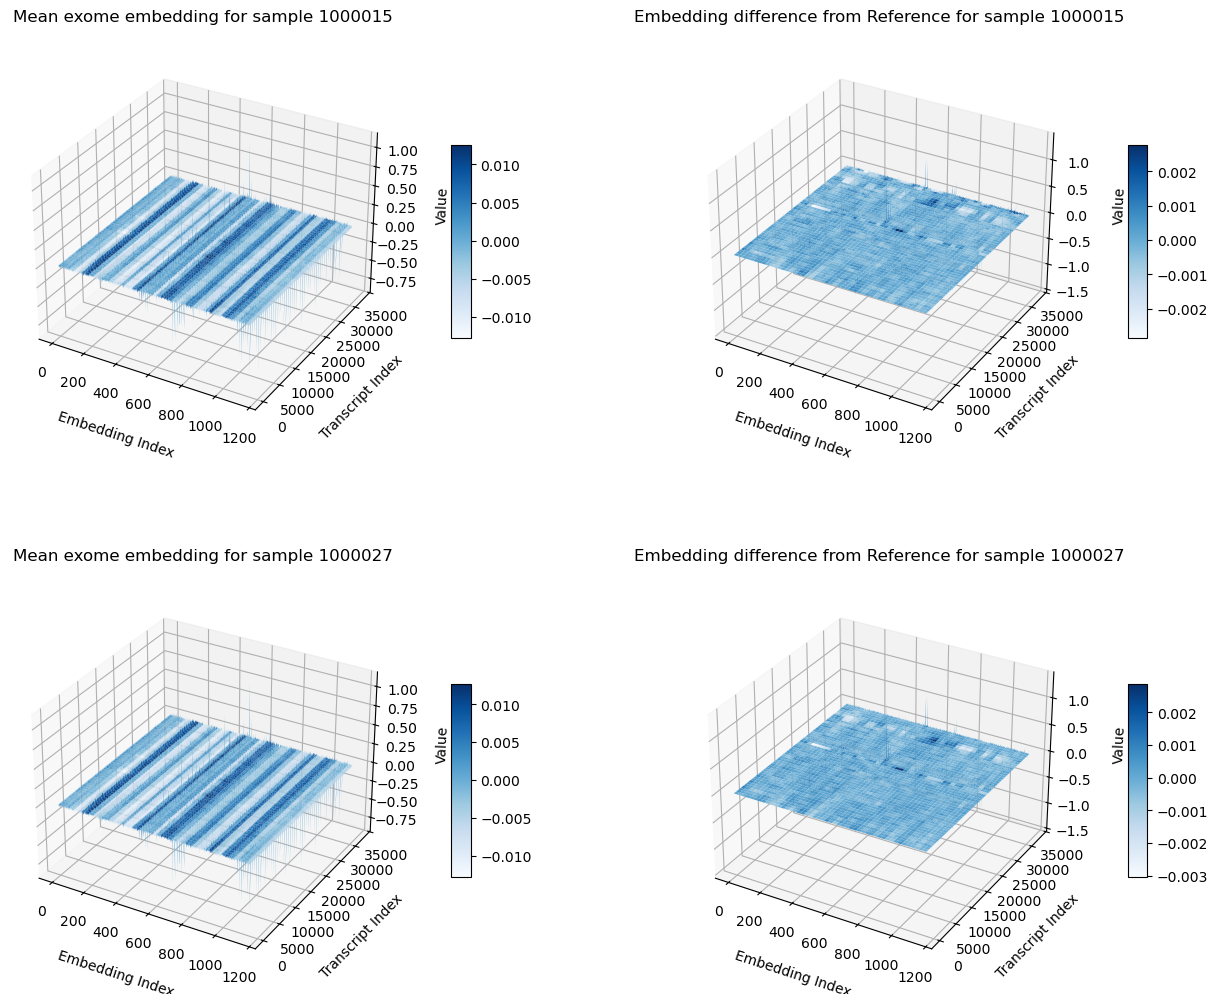

In [13]:
mean_sample_ids = list(mean_data.keys())[:2]
visualize_exome_embeddings_batch(mean_data, mean_ref, mean_sample_ids, "Mean")

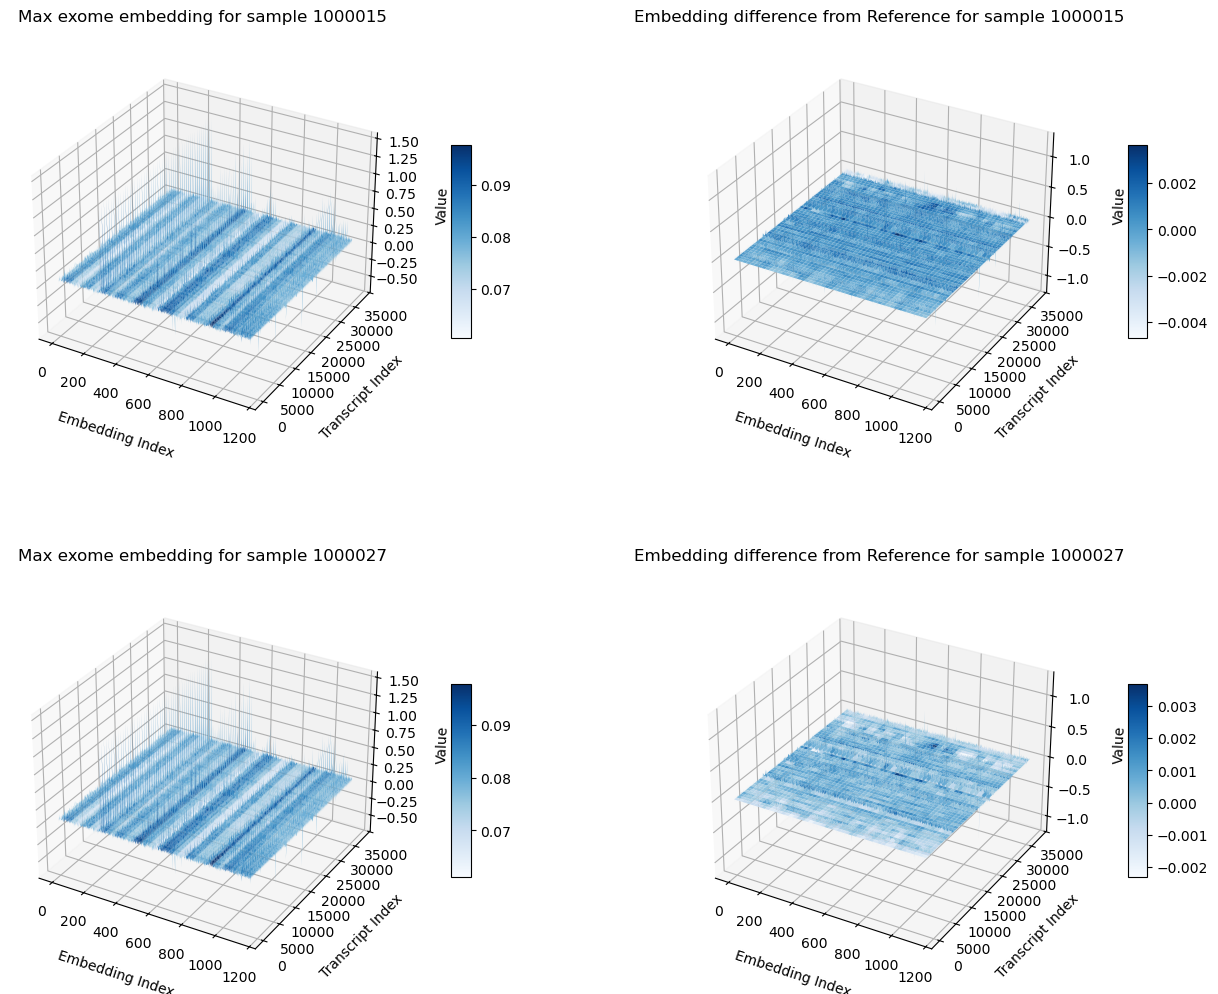

In [14]:
max_sample_ids = list(max_data.keys())[:2]
visualize_exome_embeddings_batch(max_data, max_ref, max_sample_ids, "Max")